In [1]:
from tensorflow.keras.layers import Input, Layer, ReLU, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Add, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pre-processing of the images

In [4]:
img_rows, img_cols = 224, 224
channel_depth = 3
input_shape = (img_rows,img_cols,channel_depth)
model_input = Input(shape=input_shape)

train_path="swatdcnn/data/Augmented/stage_1/train"
test_path="swatdcnn/test/stage-1/test"
val_path="swatdcnn/data/Augmented/stage_1/validation"

In [5]:
IMG_SIZE = (224,224)

def ImgDataGen(file_path,f=False):    
    file_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    file_set = file_datagen.flow_from_directory(file_path,
                                                target_size = IMG_SIZE,
                                                batch_size = 16,
                                                class_mode = 'categorical',
                                                shuffle = f)
    return file_set


In [6]:
training_set, test_set, val_set = ImgDataGen(train_path, f=True), ImgDataGen(test_path), ImgDataGen(val_path)

Found 6000 images belonging to 2 classes.
Found 468 images belonging to 2 classes.
Found 933 images belonging to 2 classes.


In [9]:
nb_train_samples = len(training_set.filenames)
nb_validation_samples = len(val_set.filenames)
nb_test_samples = len(test_set.filenames)
num_classes= len(training_set.class_indices)
labels = [i for i in training_set.class_indices]
print(labels)

['0_Healthy', '1_Unhealthy']


# Training using DenseNet121

In [10]:
def my_model(model_input):
    densenet = DenseNet121(weights='imagenet', include_top=False, input_tensor=model_input)
    for layer in densenet.layers:layer.trainable = False
    # our layers - you can add more if you want
    y = GlobalAveragePooling2D()(densenet.output)
    y = Dense(512, activation='relu', use_bias=True)(y)
    y = Dropout(0.5)(y)
    prediction = Dense(num_classes,activation='softmax')(y)
    model = Model(inputs=densenet.input, outputs=prediction)
    # tell the model what cost and optimization method to use
    return model

In [11]:
model = my_model(model_input)

In [12]:
#MODEL COMPILATION WITH HYPER-PARAMETERS, LOSS FUNCTIONS AND TRAINING!
import time

batch_size = 16

epochs = 25

start_time = time.time()

optimizer = Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
) 

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.5, 
    patience=2,                          
    verbose=1, 
    mode='max', 
    min_lr=0.000001
)

callbacks = [reduce_lr]

history = model.fit(
    training_set,
    epochs=epochs, 
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=val_set,
    callbacks=callbacks, 
    validation_steps=nb_validation_samples // batch_size, 
    verbose=1
)

elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))





Epoch 1/25
375/375 [==============================] - 481s 1s/step - loss: 0.3831 - accuracy: 0.8297 - val_loss: 0.2350 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 2/25
375/375 [==============================] - 453s 1s/step - loss: 0.2156 - accuracy: 0.9083 - val_loss: 0.2205 - val_accuracy: 0.9019 - lr: 1.0000e-04
Epoch 3/25
375/375 [==============================] - 448s 1s/step - loss: 0.1787 - accuracy: 0.9272 - val_loss: 0.1819 - val_accuracy: 0.9224 - lr: 1.0000e-04
Epoch 4/25
375/375 [==============================] - 462s 1s/step - loss: 0.1720 - accuracy: 0.9322 - val_loss: 0.1720 - val_accuracy: 0.9289 - lr: 1.0000e-04
Epoch 5/25
375/375 [==============================] - 431s 1s/step - loss: 0.1531 - accuracy: 0.9438 - val_loss: 0.1797 - val_accuracy: 0.9224 - lr: 1.0000e-04
Epoch 6/25
375/375 [==============================] - 430s 1s/step - loss: 0.1386 - accuracy: 0.9457 - val_loss: 0.1626 - val_accuracy: 0.9300 - lr: 1.0000e-04
Epoch 7/25
375/375 [====================

'03:04:39'

# Reporting 

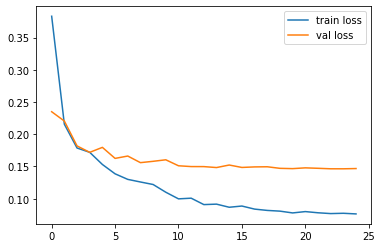

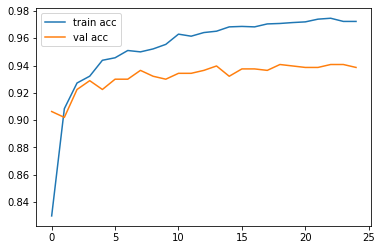

In [13]:
def report_train(history):
    # loss
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()
    # accuracies
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.legend()
    plt.show()

report_train(history)

Report Test

30/30 [==============================] - 58s 2s/step - loss: 0.1155 - accuracy: 0.9509
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       154
           1       0.96      0.96      0.96       314

    accuracy                           0.95       468
   macro avg       0.94      0.95      0.94       468
weighted avg       0.95      0.95      0.95       468



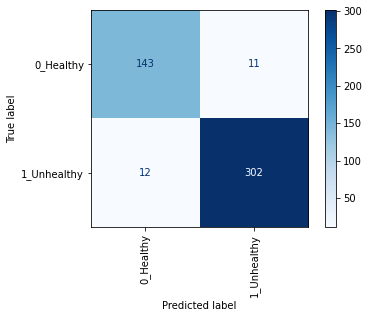

In [14]:
def report_test(test_set,model=model):
    
    # evaluating test
    model.evaluate(test_set,batch_size=32)
    y_pred=model.predict(test_set)
    y_pred=np.argmax(y_pred,axis=1)
    accuracy_score(y_pred,test_set.classes)
    print(classification_report(y_pred,test_set.classes))
    
    # confusion_matrix
    labels = [i for i in training_set.class_indices]
    cm =confusion_matrix(y_pred, test_set.classes)
    disp = ConfusionMatrixDisplay(cm,display_labels=labels)
    disp.plot(cmap='Blues',xticks_rotation='vertical')
    plt.show()

report_test(test_set)

# Export the Model

Save model

In [15]:
file_model = "DenseNet121_1.h5"
tf.keras.models.save_model(model,file_model)

Save history

In [16]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
path = 'history/'
# save to json:  
hist_json_file = 'DenseNet121_1.json' 
with open(path+hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'DenseNet121_1.csv'
with open(path+hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)